<a href="https://colab.research.google.com/github/Lucia1009/TFG-Plataforma-para-la-prediccion-de-potencia-electrica-generada-en-parques-eolicos/blob/desarrollo/modelos/comparacion_potencia_individual_y_general.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install darts -q
!pip install dash -q
!pip install --upgrade tensorflow -q
!pip install --upgrade tensorflow tensorflow_decision_forests -q
!pip install wurlitzer -q
!pip install scikeras -q
!pip install keras-tuner -q


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math


from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import R2Score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import tensorflow_decision_forests as tfdf
import ydf
import keras_tuner as kt
from wurlitzer import sys_pipes
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
import plotly.express as px
import plotly.graph_objects as go

from google.colab import drive
import pickle

# Obtención de datos del archivo

In [ ]:
drive.mount('/content/drive')

df=pd.read_csv('/content/drive/MyDrive/TFG/elvalle_reparto_saltos_sp75.csv', delimiter=";",decimal=".",skiprows = [1])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_filtrado=df[(df['TIME'] % 600==540)]
print(df_filtrado.shape)
print(df.shape)

# for col in df_filtrado:
#     print("\n",col, "\n", df_filtrado[col].unique())

(21600, 150)
(216000, 150)


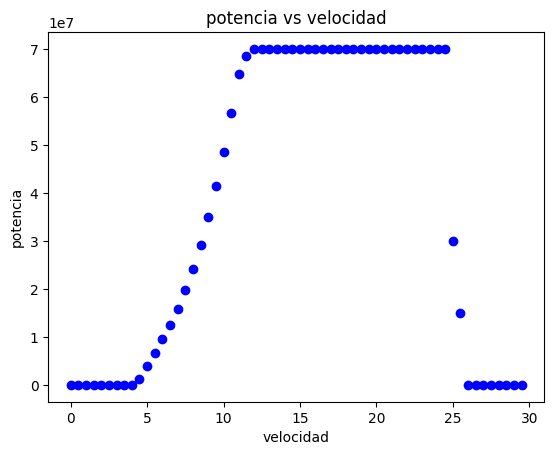

360


In [ ]:
# unique_wd, counts = np.unique(df_filtrado['wd'], return_counts=True)
# print(counts, "\n", unique_wd )

direcciones={}
for i in range(0,360):
    # Separo los datos para cada dirección
    filtered_data = df_filtrado[(df_filtrado['wd'] <= i) & (df_filtrado['wd'] > (i - 1 ))]

    # Selecciono solo las columnas que me interesan
    selected_columns = filtered_data[['ws', 'WF_Power', 'wd']]

    direcciones[i]=selected_columns
    # print(i, direcciones[i])

plt.title("potencia vs velocidad")
plt.scatter(direcciones[1]['ws'], direcciones[1]['WF_Power'], color="blue")

plt.xlabel("velocidad")
plt.ylabel("potencia")
plt.show()
print(len(direcciones))

In [ ]:
datos = pd.DataFrame(df_filtrado[['wd', 'ws', 'WF_Power']])

datos['sin_wd'] = np.sin(datos['wd']*np.pi/180)
datos['cos_wd'] = np.cos(datos['wd']*np.pi/180)
datos = datos.drop('wd', axis=1)


datos.tail()

,ws,WF_Power,sin_wd,cos_wd
215959,27.500000,1.157064e-41,-0.017452,0.999848
215969,28.000000,-1.711043e-52,-0.017452,0.999848
215979,28.500000,6.197535e-59,-0.017452,0.999848
215989,29.000000,7.481889e-71,-0.017452,0.999848
215999,29.500001,-1.019971e-84,-0.017452,0.999848


# Potencia total

In [ ]:
#### OBTENCIÓN DE DATOS ESTRATIFICADOS ####

datos_train = []
datos_test = []
for i in range(datos.shape[0]):

  if i%4==0:
      datos_test.append(datos.iloc[i])
  else:
      datos_train.append(datos.iloc[i])

print(len(datos_train), len(datos_test))
print(datos.shape[0]/len(datos_test))
print(datos.shape[0]/4)

print(datos_train[0], "\n", datos_train[1])

datos_train = pd.DataFrame(datos_train)
datos_test = pd.DataFrame(datos_test)

X_train_p = datos_train.drop('WF_Power', axis=1)
y_train_p = datos_train['WF_Power']

X_test_p = datos_test.drop('WF_Power', axis=1)
y_test_p = datos_test['WF_Power']

X_train_p.head(10)



#### OBTENCIÓN DE DATOS ALEATORIOS ####

# datos_x = datos.drop('WF_Power', axis=1)
# datos_y = datos['WF_Power']

# #Separo los datos de "train" en entrenamiento y prueba para probar los algoritmos
# X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(datos_x, datos_y, test_size=0.2 )


16200 5400
4.0
5400.0
ws          5.000000e-01
WF_Power    2.704126e-41
sin_wd      0.000000e+00
cos_wd      1.000000e+00
Name: 19, dtype: float64 
 ws          1.000000e+00
WF_Power    1.847847e-58
sin_wd      0.000000e+00
cos_wd      1.000000e+00
Name: 29, dtype: float64


,ws,sin_wd,cos_wd
19,0.5,0.0,1.0
29,1.0,0.0,1.0
39,1.5,0.0,1.0
59,2.5,0.0,1.0
69,3.0,0.0,1.0
79,3.5,0.0,1.0
99,4.5,0.0,1.0
109,5.0,0.0,1.0
119,5.5,0.0,1.0
139,6.5,0.0,1.0


In [ ]:
#### CREACIÓN DEL MODELO ####

# tf.random.set_seed(1234)

#Transformamos los datos
transformador = Pipeline([('scaler', StandardScaler()),  # normaliza los datos
                  ('poly', PolynomialFeatures(degree=15))]) ################ grado


X_train_p_transf  = transformador.fit_transform(X_train_p)
X_test_p_transf = transformador.transform(X_test_p)

print(X_train_p_transf.shape[1])

### Creamos el modelo ###

def build_model(input_shape):
  model_nn = keras.Sequential([
    keras.layers.Input(shape=(input_shape,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

  model_nn.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse', 'R2Score'])
  return model_nn

model_nn = build_model(X_train_p_transf.shape[1])

#Entrenamos el modelo
model_nn.fit(X_train_p_transf, y_train_p, epochs=40, verbose=1)   ############## epochs

#Evaluamos el modelo
model_nn.evaluate(X_test_p_transf, y_test_p)


816
Epoch 1/40
507/507 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - R2Score: -1.5170 - loss: 2534719241584640.0000 - mae: 39108392.0000 - mse: 2534719241584640.0000
Epoch 2/40
507/507 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - R2Score: -1.5158 - loss: 2523487633670144.0000 - mae: 39459744.0000 - mse: 2523487633670144.0000
Epoch 3/40
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - R2Score: -1.3251 - loss: 2341850513932288.0000 - mae: 38044368.0000 - mse: 2341850513932288.0000
Epoch 4/40
507/507 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - R2Score: -1.0661 - loss: 2091390972461056.0000 - mae: 36073320.0000 - mse: 2091390972461056.0000
Epoch 5/40
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - R2Score: -0.8077 - loss: 1810635000119296.0000 - mae: 33744260.0000 - mse: 1810635000119296.0000
Epoch 6/40
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - R2Score: -0.4727 - loss: 1482956644286464.0000 - mae: 30079768.0000 - mse: 1482956644286464.0000
Epoch 7/40
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - R2Score: -0.2024 - loss: 1217014148

[26452040876032.0, 3359249.75, 26452040876032.0, 0.974319338798523]

## Potencias individuales

In [ ]:
##### Obtención de datos ####

columns_datos = ['wd']
columns_potencias = []

for j in range(1, 15):
    # Selecciono solo las columnas que me interesan
    columns_potencias.append('TC' + str(j) + '.T.Pg.signal[1]')
    if j < 10:
        columns_datos.append('v[0' + str(j) + ']')
    else:
        columns_datos.append('v[' + str(j) + ']')

datos_x_turb = df_filtrado[columns_datos].copy()
datos_x_turb['sin_wd'] = np.sin(datos_x_turb['wd'] * np.pi / 180)
datos_x_turb['cos_wd'] = np.cos(datos_x_turb['wd'] * np.pi / 180)
datos_x_turb = datos_x_turb.drop('wd', axis=1)

datos_y_turb = df_filtrado[columns_potencias].copy()

columns_datos.remove('wd')
columns_datos.append('sin_wd')
columns_datos.append('cos_wd')

#### OBTENCIÓN DE DATOS ESTRATIFICADOS ####

X_test_turb = []
y_test_turb = []
X_train_turb = []
y_train_turb = []
for i in range(datos.shape[0]):

  if i%4==0:
      X_test_turb.append(datos_x_turb.iloc[i])
      y_test_turb.append(datos_y_turb.iloc[i])
  else:
      X_train_turb.append(datos_x_turb.iloc[i])
      y_train_turb.append(datos_y_turb.iloc[i])


X_test_p_turb = pd.DataFrame(X_test_turb)
y_test_p_turb = pd.DataFrame(y_test_turb)
X_train_p_turb = pd.DataFrame(X_train_turb)
y_train_p_turb = pd.DataFrame(y_train_turb)



In [ ]:
# # Separar datos de entrenamiento y prueba
# X_train_p_turb, X_test_p_turb, y_train_p_turb, y_test_p_turb = train_test_split(datos_x_turb, datos_y_turb, test_size=0.2)

# Transformación de datos
transformador_turb = Pipeline([('scaler', StandardScaler()), ('poly', PolynomialFeatures(degree=3))])
X_train_p_transf_turb = transformador_turb.fit_transform(X_train_p_turb)
X_test_p_transf_turb = transformador_turb.transform(X_test_p_turb)

# Modelo de red neuronal
def build_model(input_shape, output_shape):
    model_nn_turb = keras.Sequential([
        keras.layers.Input(shape=(input_shape,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(output_shape)
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model_nn_turb.compile(loss='mse', optimizer=optimizer, metrics=['R2Score','mae', 'mse'])
    return model_nn_turb

model_nn_turb = build_model(X_train_p_transf_turb.shape[1], len(columns_potencias))
model_nn_turb.fit(X_train_p_transf_turb, y_train_p_turb, epochs=40, verbose=1)
model_nn_turb.evaluate(X_test_p_transf_turb, y_test_p_turb)

Epoch 1/40
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - R2Score: -1.4978 - loss: 13074248499200.0000 - mae: 2816537.7500 - mse: 13074248499200.0000
Epoch 2/40
507/507 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - R2Score: -1.3597 - loss: 12486861389824.0000 - mae: 2910285.0000 - mse: 12486861389824.0000
Epoch 3/40
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - R2Score: -1.3772 - loss: 12476097757184.0000 - mae: 2970640.2500 - mse: 12476097757184.0000
Epoch 4/40
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - R2Score: -1.3195 - loss: 12239302033408.0000 - mae: 2973031.2500 - mse: 12239302033408.0000
Epoch 5/40
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - R2Score: -1.3043 - loss: 12131784196096.0000 - mae: 2995368.7500 - mse: 12131784196096.0000
Epoch 6/40
507/507 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - R2Score: -1.2488 - loss: 11791178399744.0000 - mae: 2973854.2500 - mse: 11791178399744.0000
Epoch 7/40
507/507 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - R2Score: -1.2180 - loss: 11669151416320.0000 - mae: 2967861.2500 - mse

[210819334144.0, 0.9601031541824341, 282952.84375, 210819334144.0]

# Comparación

In [ ]:
#### GRAFICA REGRESIÓN ####

app = dash.Dash(__name__)

app.layout = html.Div([

    html.Div([
        "Ángulo de viento: ",
        dcc.Input(id='angulo', value=0, type='number')
    ]),
    dcc.Graph(id='graph')
])

@app.callback(
    Output('graph', 'figure'),
    Input('angulo', 'value'))
def update_output_div(angulo):
    sin_angulo_val = np.sin(angulo * np.pi / 180)
    cos_angulo_val = np.cos(angulo * np.pi / 180)

    # Crear la gráfica
    fig = go.Figure()


    # REALES

    # Filtrar todos los datos (tanto entrenamiento como test) con el ángulo
    df_filtrado_datos = datos[(datos['sin_wd'] == sin_angulo_val) &
                  (datos['cos_wd'] == cos_angulo_val)]

    df_filtrado_datos = df_filtrado_datos.sort_values(by='ws')
    y_filtrado_datos = df_filtrado_datos['WF_Power']
    # Filtrar los datos de test
    df_filtrado_graf = X_test_p[(X_test_p['sin_wd'] == sin_angulo_val) &
                                (X_test_p['cos_wd'] == cos_angulo_val)]
    y_filtrado = y_test_p.loc[df_filtrado_graf.index]

    # Datos reales (puntos)
    fig.add_trace(go.Scatter(x=df_filtrado_graf['ws'], y=y_filtrado,
                              mode='markers', name='Potencia real',
                              marker=dict(color='blue')))

    # Línea continua para las predicciones
    rango_x = np.linspace(df_filtrado_graf['ws'].min(), df_filtrado_graf['ws'].max(), 100)
    # Interpolar una línea de los valores reales
    rango_y_real = np.interp(rango_x, df_filtrado_datos['ws'], y_filtrado_datos)

    # Línea continua para los valores reales
    fig.add_trace(go.Scatter(x=rango_x, y=rango_y_real, mode='lines', name='Línea real', line=dict(color='blue')))



    #MODELO GENERAL

    # Transformar los datos filtrados para predicción
    df_filtrado_transf = transformador.transform(df_filtrado_graf)
    y_pred_filtrado = model_nn.predict(df_filtrado_transf)

    # Predicciones (puntos)
    fig.add_trace(go.Scatter(x=df_filtrado_graf['ws'], y=y_pred_filtrado.flatten(),
                              mode='markers', name='Potencia predicha test parque',
                              marker=dict(color='green')))

    # Crear un DataFrame para el rango
    rango_df = pd.DataFrame({'ws': rango_x, 'sin_wd': [sin_angulo_val] * 100, 'cos_wd': [cos_angulo_val] * 100})

    # Transformar el rango de x
    rango_x_transf = transformador.transform(rango_df)

    # Predicción de los valores en el rango
    rango_y_pred = model_nn.predict(rango_x_transf)
    fig.add_trace(go.Scatter(x=rango_x, y=rango_y_pred.flatten(), mode='lines', name='Línea predicción', line=dict(color='green')))


    # SUMA

    # Seleccionar velocidad para el eje x de la suma de potencias individuales
    velocidad = f'v[02]'

    # Filtrar todos los datos con base en el ángulo
    datos_filtrados_x = datos_x_turb[(datos_x_turb['sin_wd'] == sin_angulo_val) &
                            (datos_x_turb['cos_wd'] == cos_angulo_val)]


    datos_filtrados_y = datos_y_turb[(datos_x_turb['sin_wd'] == sin_angulo_val) &
                            (datos_x_turb['cos_wd'] == cos_angulo_val)]

    datos_filtrados_test = X_test_p_turb[(X_test_p_turb['sin_wd'] == sin_angulo_val) &
                                          (X_test_p_turb['cos_wd'] == cos_angulo_val)]

    y_test_filtrado = y_test_p_turb[(X_test_p_turb['sin_wd'] == sin_angulo_val) &
                                    (X_test_p_turb['cos_wd'] == cos_angulo_val)]

    # Predecir los valores de test
    datos_x_test_transf = transformador_turb.transform(datos_filtrados_test)
    datos_y_test_pred = model_nn_turb.predict(datos_x_test_transf)

    datos_y_test_sum=datos_y_test_pred.sum(axis=1)


    # Use the index to access the predicted values for that column
    fig.add_trace(go.Scatter(x=datos_filtrados_test[velocidad], y=datos_y_test_sum,
                              mode='markers', name='Potencia predicha test (suma)',
                              marker=dict(color='red')))


    # Predicciones en el rango completo de velocidad

    rango_x_graf = datos_filtrados_x.iloc[range(0,len(datos_filtrados_x), 2)]  #Tomar de 2 en 2


    # Transformar y predecir en el rango de velocidades
    rango_df_transf_graf = transformador_turb.transform(rango_x_graf)
    rango_y_pred_graf = model_nn_turb.predict(rango_df_transf_graf)
    rango_y_pred_graf_sum = rango_y_pred_graf.sum(axis=1)

    # Añadir línea de predicción continua
    fig.add_trace(go.Scatter(x=rango_x_graf[velocidad], y=rango_y_pred_graf_sum,
                        mode='lines', name='Línea predicción',
                        line=dict(color='red')))


    fig.update_layout(
        title="Potencia vs. Velocidad",
        xaxis_title=f"Velocidad del viento (ws)",
        yaxis_title=f"Potencia (WF_Power)"
    )

    return fig




if __name__ == '__main__':
    app.run(debug=True, port=8056)


<IPython.core.display.Javascript object>

In [ ]:
def compara(model_nn,model_nn_turb, X_test_p, y_test_p, X_test_p_turb, y_test_p_turb):

    #Metricas de la suma

    datos_x_test_transf = transformador_turb.transform(X_test_p_turb)
    datos_y_test_pred = model_nn_turb.predict(datos_x_test_transf)

    datos_y_test_sum=datos_y_test_pred.sum(axis=1)

    y_test_p_sum = y_test_p_turb.sum(axis=1)


    r2_suma = r2_score(y_test_p_sum, datos_y_test_sum)
    mse_suma = mean_squared_error(y_test_p_sum, datos_y_test_sum)
    mae_suma = mean_absolute_error(y_test_p_sum, datos_y_test_sum)

    #Metricas del parque

    datos_x_test_transf = transformador.transform(X_test_p)
    datos_y_test_pred = model_nn.predict(datos_x_test_transf)


    r2_parque = r2_score(y_test_p, datos_y_test_pred)
    mse_parque = mean_squared_error(y_test_p, datos_y_test_pred)
    mae_parque = mean_absolute_error(y_test_p, datos_y_test_pred)

    return r2_parque, r2_suma, mse_parque, mse_suma, mae_parque, mae_suma

r2_parque, r2_suma, mse_parque, mse_suma, mae_parque, mae_suma = compara(model_nn,model_nn_turb, X_test_p, y_test_p, X_test_p_turb, y_test_p_turb)


#Comparación de resultados

print("\nR2Score parque:", r2_parque)
print("R2Score suma:", r2_suma)
print("diferencia parque-suma:", r2_parque-r2_suma)

print("\nMSE parque:", mse_parque)
print("MSE suma:", mse_suma)
print("diferencia parque-suma:", mse_parque-mse_suma)

print("\nMAE parque:", mae_parque)
print("MAE suma:", mae_suma)
print("diferencia parque-suma:", mae_parque-mae_suma)


169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

R2Score parque: 0.9743193441035531
R2Score suma: 0.9653227176802148
diferencia parque-suma: 0.008996626423338316

MSE parque: 26452042662979.28
MSE suma: 35718906675530.76
diferencia parque-suma: -9266864012551.477

MAE parque: 3359249.4041480864
MAE suma: 3462427.9108651932
diferencia parque-suma: -103178.5067171068


In [ ]:
# model_nn.save('/content/drive/MyDrive/TFG/modelo_potencia_parque.keras')
# model_nn_turb.save('/content/drive/MyDrive/TFG/modelo_potencia_turbinas.keras')

In [ ]:
# r2_sum=0
# r2_parq=0

# mse_sum=0
# mse_parq=0

# mae_sum=0
# mae_parq=0

# r2_p = r2_s = mse_p = mse_s = mae_p = mae_s = 0

# for i in range(3, 0, -1):

#   print(i)

#   print('entrenando modelo del parque...')

#   model_nn = build_model(X_train_p_transf.shape[1], 1)
#   model_nn.fit(X_train_p_transf, y_train_p, epochs=40, verbose=0)

#   print('entrenando modelo de la suma...')

#   model_nn_turb = build_model(X_train_p_transf_turb.shape[1], len(columns_potencias))
#   model_nn_turb.fit(X_train_p_transf_turb, y_train_p_turb, epochs=40, verbose=0)

#   r2_p, r2_s, mse_p, mse_s, mae_p, mae_s = compara(model_nn,model_nn_turb, X_test_p, y_test_p, X_test_p_turb, y_test_p_turb)
#   r2_sum+=r2_s
#   r2_parq+=r2_p
#   mse_sum+=mse_s
#   mse_parq+=mse_p
#   mae_sum+=mae_s
#   mae_parq+=mae_p

# print("\nR2Score medio parque:", r2_parq/3)
# print("R2Score medio suma:", r2_sum/3)
# print("diferencia media parque-suma:", (r2_parq-r2_sum)/3)

# print("\nMSE medio parque:", mse_parq/3)
# print("MSE medio suma:", mse_sum/3)
# print("diferencia media parque-suma:", (mse_parq-mse_sum)/3)

# print("\nMAE medio parque:", mae_parq/3)
# print("MAE medio suma:", mae_sum/3)
# print("diferencia media parque-suma:", (mae_parq-mae_sum)/3)

# Random forest

In [ ]:
#### MODELO PARQUE ####

learner = ydf.RandomForestLearner(label="WF_Power", task = ydf.Task.REGRESSION,
                                    num_trees=301, max_depth=10,
                                    split_axis="SPARSE_OBLIQUE",categorical_algorithm="RANDOM",
                                    missing_value_policy='RANDOM_LOCAL_IMPUTATION',
                                    sparse_oblique_normalization='STANDARD_DEVIATION',
                                    compute_oob_variable_importances=True,
                                    winner_take_all=False)
model_le=learner.train(datos_train)
evaluation = learner.cross_validation(datos_test)

# Print the evaluation
print(evaluation)


# model_le.evaluate(dftest)  #Equivale a imprimir la evaluación

Train model on 16200 examples
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Model trained in 0:00:35.513176
RMSE: 346775
num examples: 5400
num examples (weighted): 5400



In [ ]:
#### MODELO SUMA ####

# scikit random forest #

regr = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=0, verbose=1)
regr.fit(X_train_p_turb, y_train_p_turb)
regr.score(X_test_p_turb, y_test_p_turb)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   10.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   44.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s


0.9937362637281548

In [ ]:
#### GRAFICA RANDOM FOREST ####

app = dash.Dash(__name__)

app.layout = html.Div([

    html.Div([
        "Ángulo de viento: ",
        dcc.Input(id='angulo', value=0, type='number')
    ]),
    dcc.Graph(id='graph')
])

@app.callback(
    Output('graph', 'figure'),
    Input('angulo', 'value'))
def update_output_div(angulo):

    sin_angulo_val = np.sin(angulo * np.pi / 180)
    cos_angulo_val = np.cos(angulo * np.pi / 180)

    # Crear la gráfica
    fig = go.Figure()


    # REALES

    # Filtrar todos los datos (tanto entrenamiento como test) con el ángulo
    df_filtrado_datos = datos[(datos['sin_wd'] == sin_angulo_val) &
                  (datos['cos_wd'] == cos_angulo_val)]

    df_filtrado_datos = df_filtrado_datos.sort_values(by='ws')
    y_filtrado_datos = df_filtrado_datos['WF_Power']
    # Filtrar los datos de test
    df_filtrado_graf = X_test_p[(X_test_p['sin_wd'] == sin_angulo_val) &
                                (X_test_p['cos_wd'] == cos_angulo_val)]
    y_filtrado = y_test_p.loc[df_filtrado_graf.index]

    # Datos reales (puntos)
    fig.add_trace(go.Scatter(x=df_filtrado_graf['ws'], y=y_filtrado,
                              mode='markers', name='Potencia real',
                              marker=dict(color='blue')))

    # Línea continua para las predicciones
    rango_x = np.linspace(df_filtrado_graf['ws'].min(), df_filtrado_graf['ws'].max(), 100)
    # Interpolar una línea de los valores reales
    rango_y_real = np.interp(rango_x, df_filtrado_datos['ws'], y_filtrado_datos)

    # Línea continua para los valores reales
    fig.add_trace(go.Scatter(x=rango_x, y=rango_y_real, mode='lines', name='Línea real', line=dict(color='blue')))



    #MODELO GENERAL

    # Hacer predicciones con el modelo
    y_pred_filtrado_graf = model_le.predict(df_filtrado_graf)

    fig.add_trace(go.Scatter(x=df_filtrado_graf['ws'], y=y_pred_filtrado_graf.flatten(),
                                  mode='markers', name='Potencia predicha parque',
                                  marker=dict(color='green')))

    rango_x_graf = df_filtrado_datos['ws']

    # Predecir los valores en el rango
    rango_y_pred_graf = model_le.predict(df_filtrado_datos[['ws', 'sin_wd', 'cos_wd']])

    # Añadir las líneas a la gráfica
    fig.add_trace(go.Scatter(x=rango_x_graf, y=rango_y_pred_graf, mode='lines', name='Línea predicción parque', line=dict(color='green')))



    # SUMA

    # Seleccionar velocidad para el eje x de la suma de potencias individuales
    velocidad = f'v[02]'

    # Filtrar todos los datos con base en el ángulo
    datos_filtrados_x = datos_x_turb[(datos_x_turb['sin_wd'] == sin_angulo_val) &
                            (datos_x_turb['cos_wd'] == cos_angulo_val)]


    datos_filtrados_y = datos_y_turb[(datos_x_turb['sin_wd'] == sin_angulo_val) &
                            (datos_x_turb['cos_wd'] == cos_angulo_val)]

    datos_filtrados_test = X_test_p_turb[(X_test_p_turb['sin_wd'] == sin_angulo_val) &
                                          (X_test_p_turb['cos_wd'] == cos_angulo_val)]

    y_test_filtrado = y_test_p_turb[(X_test_p_turb['sin_wd'] == sin_angulo_val) &
                                    (X_test_p_turb['cos_wd'] == cos_angulo_val)]

    # Predecir los valores de test

    datos_y_test_pred = regr.predict(datos_filtrados_test)

    datos_y_test_pred=datos_y_test_pred.sum(axis=1)

    # Use the index to access the predicted values for that column
    fig.add_trace(go.Scatter(x=datos_filtrados_test[velocidad], y=datos_y_test_pred,
                              mode='markers', name='Potencia predicha suma',
                              marker=dict(color='red')))


    # Predicciones en el rango completo de velocidad
    rango_x_graf = datos_filtrados_x[columns_datos]

    # Transformar y predecir en el rango de velocidades

    rango_y_pred_graf = regr.predict(rango_x_graf)

    rango_y_pred_graf_sum = rango_y_pred_graf.sum(axis=1)

    # Añadir línea de predicción continua
    fig.add_trace(go.Scatter(x=rango_x_graf[velocidad], y=rango_y_pred_graf_sum,
                        mode='lines', name='Línea predicción suma',
                        line=dict(color='red')))


    fig.update_layout(
        title="Potencia vs. Velocidad",
        xaxis_title=f"Velocidad del viento (ws)",
        yaxis_title=f"Potencia (WF_Power)"
    )


    return fig




if __name__ == '__main__':
    app.run(debug=True, port=8057)


<IPython.core.display.Javascript object>

In [ ]:
# from re import X
def compara_rf(regr, model_le, X_test_p, y_test_p, X_test_p_turb, y_test_p_turb):

  #Metricas de la suma

  datos_y_test_pred = regr.predict(X_test_p_turb)

  datos_y_test_sum=datos_y_test_pred.sum(axis=1)

  y_test_p_sum = y_test_p_turb.sum(axis=1)

  r2_suma = r2_score(y_test_p_sum, datos_y_test_sum)
  mse_suma = mean_squared_error(y_test_p_sum, datos_y_test_sum)
  mae_suma = mean_absolute_error(y_test_p_sum, datos_y_test_sum)

  #Metricas del parque

  datos_y_test_pred = model_le.predict(X_test_p)

  r2_parque = r2_score(y_test_p, datos_y_test_pred)
  mse_parque = mean_squared_error(y_test_p, datos_y_test_pred)
  mae_parque = mean_absolute_error(y_test_p, datos_y_test_pred)

  return r2_parque, r2_suma, mse_parque, mse_suma, mae_parque, mae_suma

r2_parque, r2_suma, mse_parque, mse_suma, mae_parque, mae_suma = compara_rf(regr, model_le, X_test_p, y_test_p, X_test_p_turb, y_test_p_turb)

#Comparación de resultados

print("\nR2Score parque:", r2_parque)
print("R2Score suma:", r2_suma)
print("diferencia parque-suma:", r2_parque-r2_suma)

print("\nMSE parque:", mse_parque)
print("MSE suma:", mse_suma)
print("diferencia parque-suma:", mse_parque-mse_suma)

print("\nMAE parque:", mae_parque)
print("MAE suma:", mae_suma)
print("diferencia parque-suma:", mae_parque-mae_suma)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s



R2Score parque: 0.9939703195349929
R2Score suma: 0.9961027418646978
diferencia parque-suma: -0.002132422329704897

MSE parque: 6210797946425.063
MSE suma: 4014322643325.665
diferencia parque-suma: 2196475303099.3984

MAE parque: 1254219.6879910345
MAE suma: 878222.7430931224
diferencia parque-suma: 375996.9448979121


In [ ]:
# model_le.save('/content/drive/MyDrive/TFG/modelo_potencia_parque_rf.keras')
# pickle.dump(regr, open('/content/drive/MyDrive/TFG/modelo_potencias_turbinas_rf.p', 'wb'))

In [ ]:
# r2_sum=0
# r2_parq=0

# mse_sum=0
# mse_parq=0

# mae_sum=0
# mae_parq=0

# r2_p = r2_s = mse_p = mse_s = mae_p = mae_s = 0

# for i in range(3, 0, -1):

#   print(i)

#   print('entrenando modelo del parque...')

#   learner = ydf.RandomForestLearner(label="WF_Power", task = ydf.Task.REGRESSION,
#                                     num_trees=301, max_depth=10,
#                                     split_axis="SPARSE_OBLIQUE",categorical_algorithm="RANDOM",
#                                     missing_value_policy='RANDOM_LOCAL_IMPUTATION',
#                                     sparse_oblique_normalization='STANDARD_DEVIATION',
#                                     compute_oob_variable_importances=True,
#                                     winner_take_all=False)
#   model_le=learner.train(datos_train)


#   print('entrenando modelo de la suma...')

#   regr = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=0, verbose=0)
#   regr.fit(X_train_p_turb, y_train_p_turb)

#   r2_p, r2_s, mse_p, mse_s, mae_p, mae_s = compara_rf(regr, model_le, X_test_p, y_test_p, X_test_p_turb, y_test_p_turb)
#   r2_sum+=r2_s
#   r2_parq+=r2_p
#   mse_sum+=mse_s
#   mse_parq+=mse_p
#   mae_sum+=mae_s
#   mae_parq+=mae_p

# print("\nR2Score medio parque:", r2_parq/3)
# print("R2Score medio suma:", r2_sum/3)
# print("diferencia media parque-suma:", (r2_parq-r2_sum)/3)

# print("\nMSE medio parque:", mse_parq/3)
# print("MSE medio suma:", mse_sum/3)
# print("diferencia media parque-suma:", (mse_parq-mse_sum)/3)

# print("\nMAE medio parque:", mae_parq/3)
# print("MAE medio suma:", mae_sum/3)
# print("diferencia media parque-suma:", (mae_parq-mae_sum)/3)